# CS109a - Spotify Project - Scratch notebook

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import os
import sys
import json
import time
import pickle

from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sqlalchemy as db
from sqlalchemy import Table, Column, Integer, String, MetaData, and_, or_, func,distinct
from sqlalchemy import create_engine
import sqlite3
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base 

import importlib

from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator

%env SPOTIFY_CLIENT_ID=aff9ad651d0b4181a541bc73c6852474
%env SPOTIFY_CLIENT_SECRET=258c115477814b09b93b0b04d507e929
%env SPOTIFY_REDIRECT_URI=FinalProjectCS109a://callback

env: SPOTIFY_CLIENT_ID=aff9ad651d0b4181a541bc73c6852474
env: SPOTIFY_CLIENT_SECRET=258c115477814b09b93b0b04d507e929
env: SPOTIFY_REDIRECT_URI=FinalProjectCS109a://callback


## SQLITE DB

In [2]:
# Set database path on local drive
db_path = "../data/spotify_songs.db"

# Get sesion
session = get_session(db_path)

# Get Classes
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")

In [3]:
# test
result = display_time(session.query(Tracks).first)
display(result.track_uri)

result = display_time(session.query(Artists).first)
display(result.artist_uri)

Time to Execute: 0.01 seconds


'spotify:track:2d7LPtieXdIYzf7yHPooWd'

Time to Execute: 0.0 seconds


'spotify:artist:3tBUUrQ26CCErBABEw2EXo'

## Data read functions

### Spotify Data

In [27]:
''' The staff provided data has filenames 'songs0.csv' through 'songs999.csv'
    This function returns a single dataframe containing the desired CSV files.
    Args:
        1) file_nums:  list ... List of file #s to read (e.g. 0, 1, 2 ... 999); default is to just read 'songs0.csv'
        2) songs_dir:  str  ... Where the songs CSVs reside; default is 'songs/'
    
    You can pass a single parameter "ALL_FILES" (defined below) to simply get a full dataframe of all CSVs.
'''

def read_songs_csv(file_nums: list = [0], songs_dir: str = '../data/songs/') -> pd.core.frame.DataFrame:
    # check for valid input
    if any(i < 0 for i in file_nums) or any(i > 999 for i in file_nums) or len(file_nums) == 0:
        print('ERROR - read_songs_csv: Bad parameters; file numbers are out of bounds, or list is empty')
        return
    
    # put all listed songs CSV #s into a dataframe
    df = pd.concat((pd.read_csv(songs_dir + 'songs' + str(i) + '.csv') for i in file_nums))
    
    return df

In [28]:
# for convenience, constants to read all files or a randomly selected assortment of files
# (re-run cell for a different random assortment!)

# WARNING: this will take awhile and requires ~16+ GB RAM to be even feasible (and still not worth it!)
ALL_FILES = np.arange(0, 1000, 1) 

# reads N random files
N = 10
RANDOM = np.random.randint(0, 1000, N)

In [32]:
# test
rand_songs_df = read_songs_csv(RANDOM)

rand_songs_df.describe()

,pid,pos,duration_ms
count,664158.000000,664158.000000,6.641580e+05
mean,496.614635,54.567041,2.349680e+05
std,288.522076,48.405135,7.335380e+04
min,0.000000,0.000000,0.000000e+00
25%,245.000000,17.000000,1.985730e+05
50%,495.000000,40.000000,2.252170e+05
75%,749.000000,79.000000,2.595000e+05
max,999.000000,248.000000,6.348017e+06


### LastFM

In [ ]:
''' The lastFM data set is organized into individual JSON files, in nested directories.
    This function returns a single dataframe containing JSON data. It is designed to work with
    the pre-split train/test data sets for the subset of the 300GB million song data set.
    
    Args: lastfm_dir ... ROOT directory of the data containing letter folders
                        (e.g. lastfm_train or lastfm_test). Reads train data by default '''

def read_lastfm_json(lastfm_dir: str = 'lastfm_train') -> pd.core.frame.DataFrame:
    # put all jsons in a DF
    return 

In [12]:
import json

# test = pd.read_json('lastfm_train/A/A/A/TRAAAAK128F9318786.json')
# test

with open('lastfm_train/A/A/A/TRAAAAK128F9318786.json') as json_file:
    data = json.load(json_file)

test = pd.DataFrame(data, columns=data.keys())
test

ValueError: arrays must all be same length

## Reading data Examples - Spotify

In [11]:
# Read all files to DF in memory
#               ----------- commented out, just an example
#songs_df = read_songs_csv(ALL_FILES)
#songs_df.head()

# Read randomly assorted files

songs_df = read_songs_csv(RANDOM)
songs_df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,0,Lil Uzi Vert,spotify:track:5wyrQLBbmKdxY6yLNdienj,spotify:artist:4O15NlyKLIASxsJ0PrXPfz,I Can Drive,spotify:album:6LX75kNicFqjjiAOeZgN67,153808,The Perfect LUV Tape
1,0,1,Young Thug,spotify:track:4cg1yakyRSIOjxKM2I7J1q,spotify:artist:50co4Is1HCEo8bhOyUWKpn,Digits,spotify:album:2z4c8M8aVzl7CTobIp36KF,176386,Slime Season 3
2,0,2,21 Savage,spotify:track:2kE82JhBcoS7mimFO1SqqX,spotify:artist:1URnnhqYAYcrqrcwql10ft,No Advance,spotify:album:4I3EcXD4e3KcEoDJfFEZ5b,276466,Savage Mode
3,0,3,Rich Chigga,spotify:track:7uuBfgY1vBCalrQRyyQhqs,spotify:artist:2IDLDx25HU1nQMKde4n61a,Gospel,spotify:album:79M1nv9rYaZvyt1GmyDAEa,173294,Gospel
4,0,4,Playboi Carti,spotify:track:1e1JKLEDKP7hEQzJfNAgPl,spotify:artist:699OTQXzgjhIYAHMy9RyPD,Magnolia,spotify:album:4rJgzzfFHAVFhCSt2P4I3j,181812,Playboi Carti


In [7]:
# Get some summary stats
summary_stats = {
    'total_records': songs_df['pid'].count(),
    'unique_artists': songs_df['artist_uri'].unique().size,
    'unique_songs': songs_df['track_uri'].unique().size,
    'unique_albums': songs_df['album_uri'].unique().size,
    'average_track_length': songs_df['duration_ms'].mean()
}
display(summary_stats)

{'total_records': 6649984,
 'unique_artists': 109410,
 'unique_songs': 683295,
 'unique_albums': 271958,
 'average_track_length': 234929.8703678084}

In [11]:
# Group by playlists
playlists_df = songs_df.groupby('pid').agg({
    'pos': np.mean,
    'duration_ms': np.mean
})

playlists_df

,pos,duration_ms
pid,,
0,55.481721,231016.939017
1,56.614440,234642.595866
2,48.218701,235214.725133
3,51.795475,233915.773588
4,52.793873,235971.105573
5,46.131243,229379.479841
6,53.447182,235991.526640
7,52.855638,234893.126859
8,58.281458,239455.512413


## EDA - Spotify DB

#### Columns

In [4]:
print('Playlists Columns:\n')
for c in Playlists.__table__.columns:
    print(c.name)
    
print('\nArtist columns:\n')
for c in Artists.__table__.columns:
    print(c.name)
    
print('\nTrack columns:\n')
for c in Tracks.__table__.columns:
    print(c.name)

Playlists Columns:

id
playlist_id
pos
artist_name
track_uri
artist_uri
track_name
album_uri
duration_ms
album_name

Artist columns:

artist_uri
followers
genres
artist_name
artist_popularity

Track columns:

track_uri
artist_uri
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
time_signature
track_popularity


#### Total Counts

In [5]:
counts = { 
    'track_count': session.query(func.count(distinct(Tracks.track_uri))).scalar(),
    'artist_count': session.query(func.count(distinct(Artists.artist_uri))).scalar(),
    'playlist_records_count':  session.query(func.count(Playlists.playlist_id)).scalar(),
    'playlists_count':  session.query(func.count(distinct(Playlists.playlist_id))).scalar()
    }

for k,v in counts.items():
    print(k, ':', v)

track_count : 2261597
artist_count : 296014
playlist_records_count : 66344450
playlists_count : 999001


#### Playlists

In [73]:
# songs per playlist
songs_per_playlist_count = session.query(Playlists.playlist_id, func.count(Playlists.track_name).label('count')).group_by(Playlists.playlist_id).all()

songs_per_playlist_count = np.array(songs_per_playlist_count)
display(songs_per_playlist_count[:, 1])

array([ 13,  85, 158, ...,  52,  66,  21])

In [74]:
# average song length per playlist
songs_per_playlist_avg = session.query(Playlists.playlist_id, func.avg(Playlists.duration_ms).label('avg_song_length')).group_by(Playlists.playlist_id).all()

songs_per_playlist_avg = np.array(songs_per_playlist_avg)
display(songs_per_playlist_avg[:, 1])

array([2.54620154e+05, 2.25012235e+05, 2.25930443e+05, ...,
       0.00000000e+00, 3.03030303e-02, 0.00000000e+00])

Smallest playlist: 4
Largest playlist: 459
Mean playlist length: 66.4107923815892
Median playlist length: 49.0
Mode playlist length: 20 songs ( 15028 playlists )


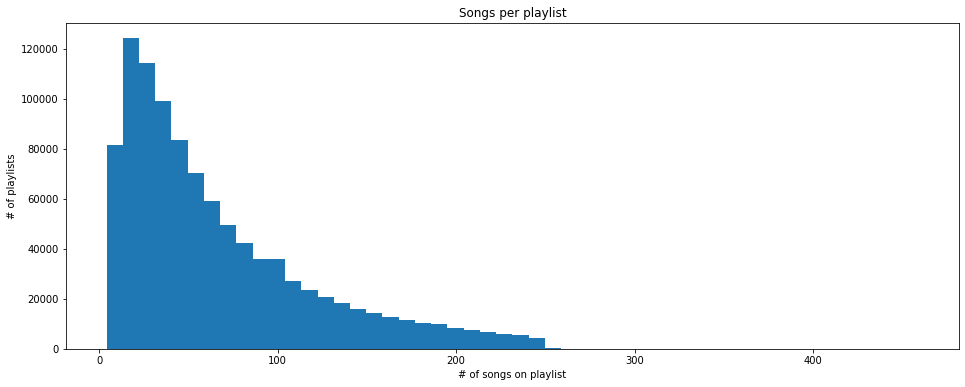

In [85]:
# plot playlist lengths
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
ax.hist(songs_per_playlist_count[:, 1], bins=50);
    
ax.set_title('Songs per playlist')
ax.set_ylabel('# of playlists')
ax.set_xlabel('# of songs on playlist');

print('Smallest playlist:', np.min(songs_per_playlist_count[:, 1]))
print('Largest playlist:', np.max(songs_per_playlist_count[:, 1]))
print('Mean playlist length:', np.mean(songs_per_playlist_count[:, 1]))
print('Median playlist length:', np.median(songs_per_playlist_count[:, 1]))
print('Mode playlist length:', stats.mode(songs_per_playlist_count[:, 1])[0][0], 'songs (',
     stats.mode(songs_per_playlist_count[:, 1])[1][0], 'playlists )')

Shortest avg length: -1.0
Longest avg length: 4350476.743589744
Mean avg length: 160710.60076846372
Median avg length: 220159.53846153847
Mode avg length: 0.0 ms ( 15028 playlists )


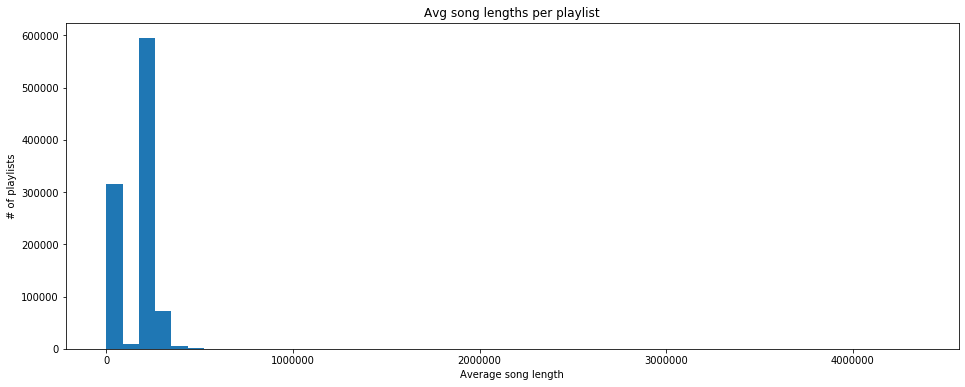

In [90]:
# plot playlist avg song lengths
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
ax.hist(songs_per_playlist_avg[:, 1], bins=50);
    
ax.set_title('Avg song lengths per playlist')
ax.set_ylabel('# of playlists')
ax.set_xlabel('Average song length');

print('Shortest avg length:', np.min(songs_per_playlist_avg[:, 1]))
print('Longest avg length:', np.max(songs_per_playlist_avg[:, 1]))
print('Mean avg length:', np.mean(songs_per_playlist_avg[:, 1]))
print('Median avg length:', np.median(songs_per_playlist_avg[:, 1]))
print('Mode avg length:', stats.mode(songs_per_playlist_avg[:, 1])[0][0], 'ms (',
     stats.mode(songs_per_playlist_count[:, 1])[1][0], 'playlists )')

In [91]:
# Most popular artists by playlist appearance (artist name)
artist_playlist_app_count = session.query(Playlists.artist_name, func.count(Playlists.artist_name).label('count')).group_by(Playlists.artist_name).all()

In [109]:
artist_playlist_app_count.sort(key=lambda x: x[1], reverse=True)
artist_playlist_app_count[:20]

[('Drake', 847159),
 ('Kanye West', 413291),
 ('Kendrick Lamar', 353624),
 ('Rihanna', 339548),
 ('The Weeknd', 316603),
 ('Eminem', 294667),
 ('Ed Sheeran', 272116),
 ('Future', 250734),
 ('Justin Bieber', 243119),
 ('J. Cole', 241560),
 ('Beyoncé', 230857),
 ('The Chainsmokers', 223509),
 ('Chris Brown', 212772),
 ('Calvin Harris', 203047),
 ('Twenty One Pilots', 198905),
 ('Lil Uzi Vert', 197855),
 ('Post Malone', 195907),
 ('Big Sean', 192478),
 ('Maroon 5', 187029),
 ('JAY Z', 185520)]

In [119]:
# Most popular tracks by playlist appearance (uri)
track_playlist_app_count = session.query(Playlists.artist_name, Playlists.track_name, func.count(Playlists.track_uri).label('count')).group_by(Playlists.track_uri).all()

In [121]:
track_playlist_app_count.sort(key=lambda x: x[2], reverse=True)
track_playlist_app_count[:20]

[('Kendrick Lamar', 'HUMBLE.', 46574),
 ('Drake', 'One Dance', 43447),
 ('DRAM', 'Broccoli (feat. Lil Yachty)', 41309),
 ('The Chainsmokers', 'Closer', 41079),
 ('Post Malone', 'Congratulations', 39987),
 ('Aminé', 'Caroline', 35202),
 ('KYLE', 'iSpy (feat. Lil Yachty)', 35138),
 ('Migos', 'Bad and Boujee (feat. Lil Uzi Vert)', 34999),
 ('Lil Uzi Vert', 'XO TOUR Llif3', 34922),
 ('Khalid', 'Location', 34657),
 ('Big Sean', 'Bounce Back', 33699),
 ('R. Kelly', 'Ignition - Remix', 32391),
 ('J. Cole', 'No Role Modelz', 32336),
 ('Future', 'Mask Off', 32059),
 ('Chance The Rapper', 'No Problem (feat. Lil Wayne & 2 Chainz)', 31492),
 ('DJ Khaled', "I'm the One", 31374),
 ('Drake', 'Jumpman', 31119),
 ('Travis Scott', 'goosebumps', 31106),
 ('Drake', 'Fake Love', 30678),
 ('Luis Fonsi', 'Despacito - Remix', 30485)]

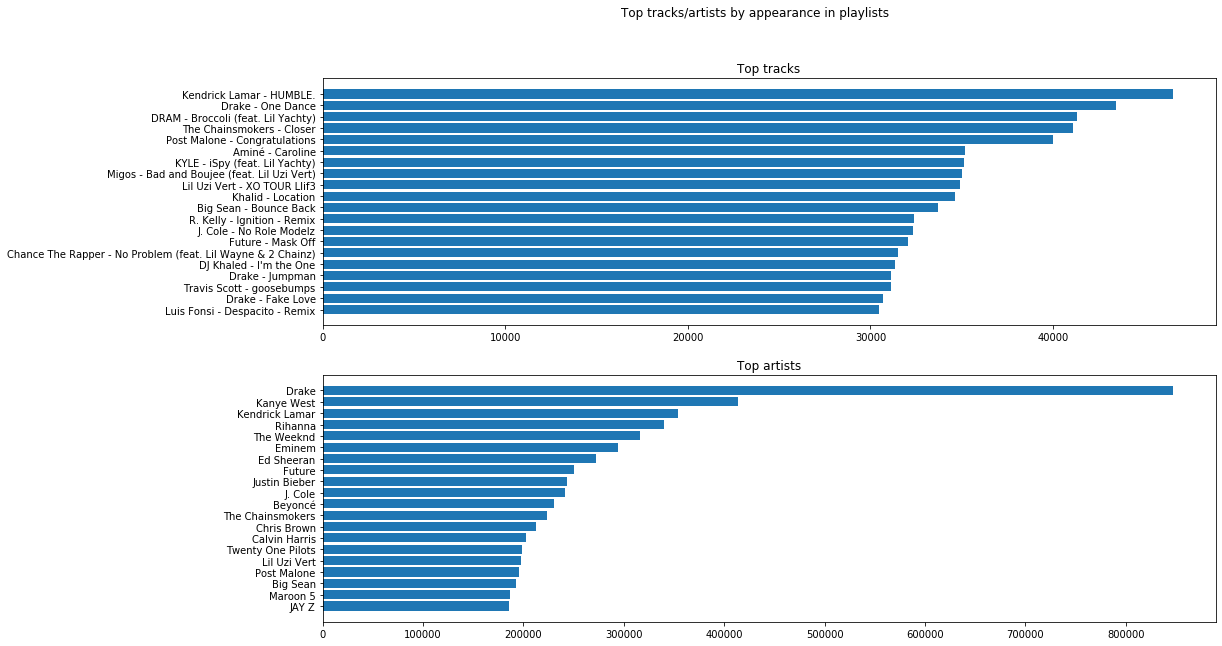

In [137]:
top20_track_counts = [x[2] for x in track_playlist_app_count[:20]]
top20_track_labels = [x[0] + ' - ' + x[1] for x in track_playlist_app_count[:20]]

top20_artist_counts = [x[1] for x in artist_playlist_app_count[:20]]
top20_artist_labels = [x[0] for x in artist_playlist_app_count[:20]]

top20_track_counts.reverse()
top20_track_labels.reverse()
top20_artist_counts.reverse()
top20_artist_labels.reverse()

# barplots for 20 most popular artists/tracks
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

y1 = np.arange(len(top20_track_counts))
y2 = np.arange(len(top20_artist_counts))
    
axs[0].barh(y1, top20_track_counts)
    
axs[0].set_title('Top tracks')
# axs[0].set_ylabel('# of playlists')
# axs[0].set_xlabel('Average song length')
axs[0].set_yticks(y1)
axs[0].set_yticklabels(top20_track_labels)

axs[1].barh(y2, top20_artist_counts)
    
axs[1].set_title('Top artists')
# axs[1].set_ylabel('# of playlists')
# axs[1].set_xlabel('Average song length')
axs[1].set_yticks(y2)
axs[1].set_yticklabels(top20_artist_labels)

fig.suptitle('Top tracks/artists by appearance in playlists');

#### Artists

In [141]:
artist_popularities = session.query(Artists.artist_popularity).all()
artist_popularities = [x[0] for x in artist_popularities] 
artist_popularities[:10]

[0, 8, 5, 40, 21, 0, 7, 37, 40, 38]

Min popularity: 0
Max popularity: 100
Average popularity: 16.3771983757525
Median popularity: 11.0
Mode popularity: 0 ( 15028 artists )


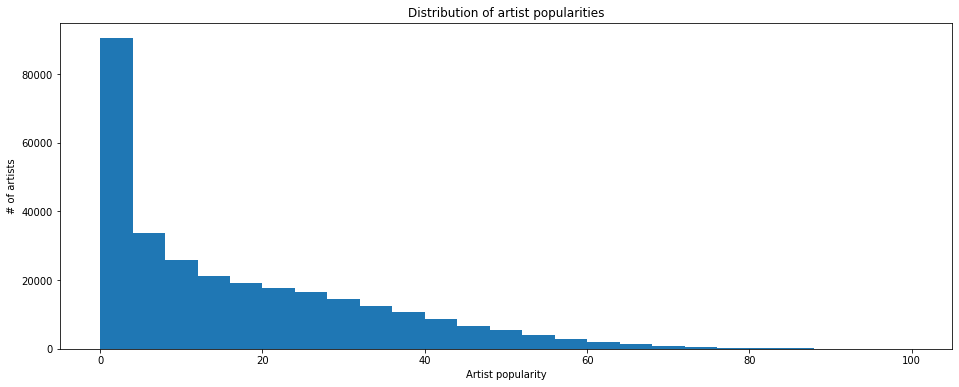

In [144]:
# plot playlist avg song lengths
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
ax.hist(artist_popularities, bins=25);
    
ax.set_title('Distribution of artist popularities')
ax.set_ylabel('# of artists')
ax.set_xlabel('Artist popularity');

print('Min popularity:', np.min(artist_popularities))
print('Max popularity:', np.max(artist_popularities))
print('Average popularity:', np.mean(artist_popularities))
print('Median popularity:', np.median(artist_popularities))
print('Mode popularity:', stats.mode(artist_popularities)[0][0], '(',
     stats.mode(songs_per_playlist_count[:, 1])[1][0], 'artists )')

In [158]:
artist_genres = session.query(Artists.genres, func.count(Artists.genres)).group_by(Artists.genres).all()
artist_genres.sort(key=lambda x: x[1], reverse=True)

print('TOTAL:', len(artist_genres))
print(artist_genres[:20])

TOTAL: 30167
[('', 181365), ('fake', 202), ('karaoke', 188), ('deep underground hip hop', 186), ('praise', 185), ('sleep', 181), ('indie electropop', 149), ('country pop', 145), ('relaxative', 136), ('deep pop r&b', 132), ('deep talent show', 125), ('regional mexican pop', 120), ('sky room', 119), ('deep tropical house', 118), ('vapor soul', 118), ('indie anthem-folk', 117), ('deep dubstep', 116), ('workout product', 116), ('pop reggaeton', 115), ('channel pop', 114)]


#### Tracks

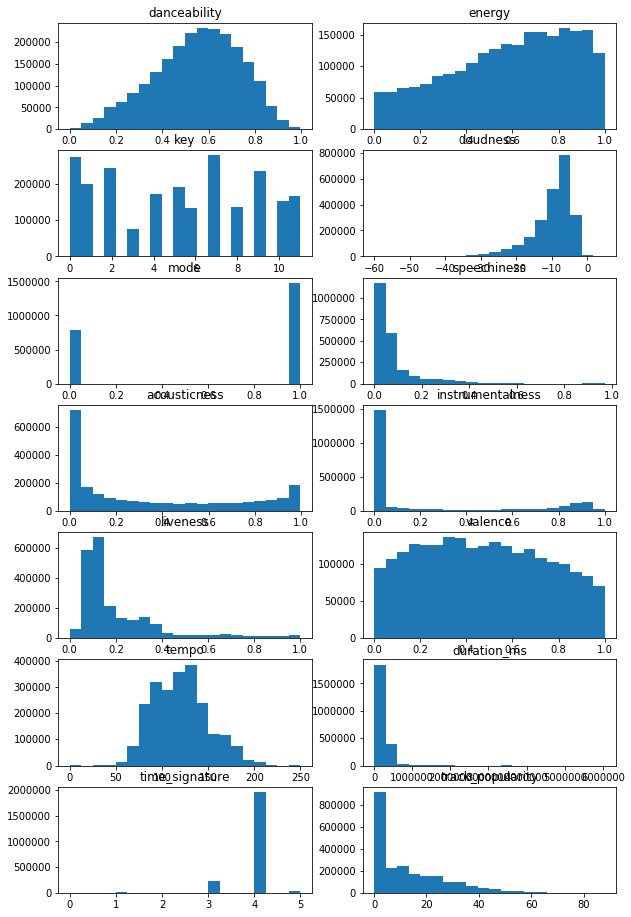

In [186]:
track_feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                      'duration_ms', 'time_signature', 'track_popularity']

# plot distributions of each track attribute
fig, axs = plt.subplots(7, 2, figsize=(16, 16))

# plot individual values by fold
for i, ax in enumerate(axs.ravel()):
    tr_feature = session.query(getattr(Tracks, track_feature_cols[i])).all()
    tr_feature = [x[0] is not None and x[0] or 0 for x in tr_feature]
    ax.hist(tr_feature, bins=20)
    ax.set_title(track_feature_cols[i]);